# Equations of motion for control moment gyroscope

In [1]:
import sympy as sym
import numpy as np

The `sympy.physics.mechanics` module makes it easier to work with (and display) time derivatives.

In [2]:
from sympy.physics import mechanics
mechanics.init_vprinting()

Define parameters in symbolic form.

In [3]:
# Principal moments of inertia
J_1x, J_1y, J_1z = sym.symbols('J_1x, J_1y, J_1z')
J_2x, J_2y, J_2z = sym.symbols('J_2x, J_2y, J_2z')
J_3x, J_3y, J_3z = sym.symbols('J_3x, J_3y, J_3z')

# Moment of inertia matrices in body-fixed reference frames
J1 = sym.Matrix.diag(J_1x, J_1y, J_1z)
J2 = sym.Matrix.diag(J_2x, J_2y, J_2z)
J3 = sym.Matrix.diag(J_3x, J_3y, J_3z)

# Spar length
r = sym.symbols('r')

# Load mass
m = sym.symbols('m')

# Acceleration of gravity
g = sym.symbols('g')

Define variables.

In [4]:
# Time
t = sym.Symbol('t')

# Joint angles:
q1, q2, q3 = mechanics.dynamicsymbols('q1, q2, q3')

# Joint velocities
v1 = q1.diff(t)
v2 = q2.diff(t)
v3 = q3.diff(t)

# Joint accelerations
a1 = v1.diff(t)
a2 = v2.diff(t)
a3 = v3.diff(t)

# Torques:
tau2, tau3 = sym.symbols('tau2, tau3')

Compute angular velocity of each link with respect to body-fixed reference frames (the choice of frame is very important - using a space-fixed reference frame is a common mistake).

In [23]:
c1 = sym.cos(q1)
s1 = sym.sin(q1)
R_p_in_w = sym.Matrix([[c1, -s1, 0], [s1, c1, 0], [0, 0, 1]])

c2 = sym.cos(q2)
s2 = sym.sin(q2)
R_g_in_p = sym.Matrix([[1, 0, 0], [0, c2, -s2], [0, s2, c2]])

w1 = sym.Matrix([[0], [0], [v1]])
w2 = R_p_in_w.T * w1 + sym.Matrix([[v2], [0], [0]])
w3 = R_g_in_p.T * w2 + sym.Matrix([[0], [-v3], [0]])

# Show result
print(w3)


Matrix([[Derivative(q2(t), t)], [sin(q2(t))*Derivative(q1(t), t) - Derivative(q3(t), t)], [cos(q2(t))*Derivative(q1(t), t)]])


Compute position and velocity of load mass.

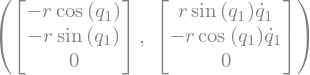

In [13]:
p = R_p_in_w * sym.Matrix([-r, 0, 0])
v = p.diff(t)

# Show result
p, v

Compute Lagrangian.

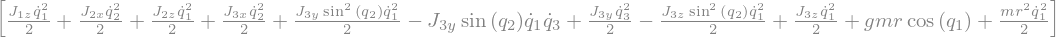

In [15]:
T = ((w1.T * J1 * w1) + (w2.T * J2 * w2) + (w3.T * J3 * w3) + (v.T * m * v)) / 2
V = m * g * (sym.Matrix([1, 0, 0]).T * p)
L = sym.simplify(T - V)

# Show result
L

Compute equations of motion.

In [16]:
EOM = L.jacobian([v1, v2, v3]).diff(t) - L.jacobian([q1, q2, q3]) - sym.Matrix([0, tau2, tau3]).T

Simplify equations of motion by solving for accelerations.

In [17]:
sol = sym.solve(EOM, [a1, a2, a3])
h = sym.together(sym.simplify(sym.Matrix([sol[a1], sol[a2], sol[a3]]), full=True))

Assume $\tau_3=0$ and look only at the equations of motion that govern the platform and the gimbal:

In [18]:
h = h[0:2, 0].subs(tau3, 0)

Display the vector-valued function $h$ for which the equations of motion can be written as

$$\begin{bmatrix} \ddot{q}_1 \\ \ddot{q}_2 \end{bmatrix} = h(q_1, q_2, \dot{q}_1, \dot{q}_2, \tau_2)$$

where everything else (mass and inertial parameters, spar length, acceleration of gravity, and rotor velocity $\dot{q}_3$) is assumed constant.

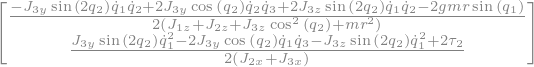

In [21]:
h

Display $h$ as latex-formatted text that could be copy/pasted into a $\LaTeX$ document (or into markdown).

In [20]:
print(f'{mechanics.mlatex(h)}')

\left[\begin{matrix}\frac{- J_{3y} \sin{\left(2 q_{2} \right)} \dot{q}_{1} \dot{q}_{2} + 2 J_{3y} \cos{\left(q_{2} \right)} \dot{q}_{2} \dot{q}_{3} + 2 J_{3z} \sin{\left(2 q_{2} \right)} \dot{q}_{1} \dot{q}_{2} - 2 g m r \sin{\left(q_{1} \right)}}{2 \left(J_{1z} + J_{2z} + J_{3z} \cos^{2}{\left(q_{2} \right)} + m r^{2}\right)}\\\frac{J_{3y} \sin{\left(2 q_{2} \right)} \dot{q}_{1}^{2} - 2 J_{3y} \cos{\left(q_{2} \right)} \dot{q}_{1} \dot{q}_{3} - J_{3z} \sin{\left(2 q_{2} \right)} \dot{q}_{1}^{2} + 2 \tau_{2}}{2 \left(J_{2x} + J_{3x}\right)}\end{matrix}\right]


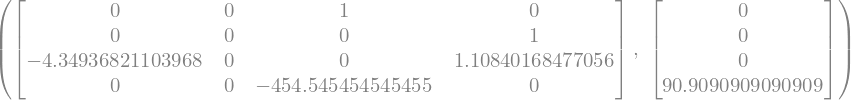

In [41]:
q1, q2, v1, v2, T = mechanics.dynamicsymbols('q1, q2, v1, v2, T')
V, J_1z, J_2x, J_2z, J_3x, J_3y, J_3z, m, r, g = 500, .5, .001, .001, .01, .01, .01, 1, 2, 9.81
a1 = -J_3y + 2*J_3z
a2 = 2*J_3y
a3 = -2*g*m*r
a4 = 2*J_1z + 2*J_2z + 2*m*r*r
a5 = 2*J_3z
a6 = (J_3y - J_3z)/(2*(J_2x + J_3x))
a7 = -1*J_3y / (J_2x + J_3x)
a8 = 1/(J_2x + J_3x)

m = sym.Matrix([q1, q2, v1 ,v2])
n = sym.Matrix([T])
m_dot = sym.Matrix([
    v1, 
    v2,
    (a1*sym.sin(2*q2)*v1*v2 + a2*sym.cos(q2)*v2*V + a3*sym.sin(q1))/(a4 + a5*sym.cos(q2)*sym.cos(q2)),
    a6*sym.sin(2*q2)*v1*v1 + a7*sym.cos(q2)*v1*V + a8*T
])
m_e = sym.Matrix([0, 0, 0, 0]) #equilibrium points
n_e = sym.Matrix([0])
A_raw = m_dot.jacobian(m) #raw meaning that the equilibrium points have not been subbed in
B_raw = m_dot.jacobian(n)


A = A_raw.subs([(q1, m_e[0]), (q2, m_e[1]), (v1, m_e[2]), (v2, m_e[3])])
B = B_raw.subs(T, 0)

A, B